# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

RANDOM_STATE = 37

#Собственные реализации классификаторов

##Реализация SVM

In [204]:
from sklearn.base import BaseEstimator

class MySVMClassifier(BaseEstimator):
    def __init__(self, alpha=1e-1, Lambda=1e-1, num_iter=10):
        self._alpha = alpha
        self._lambda = Lambda
        self._num_iter = num_iter

    def fit(self, X_train, y_train):
        y_train_labels = np.where(y_train <= 0, -1, 1)
        self.weights = np.zeros(X_train.shape[1])
        self.bias = 0
        for iter in range(self._num_iter):
            for i, x_i in enumerate(X_train):
                dw = 0
                db = 0
                M = y_train_labels[i] * (np.dot(x_i, self.weights) - self.bias)
                if  M >= 1:
                    dw = 2 * self._lambda * self.weights
                    db = 0
                else:
                    dw = 2 * self._lambda * self.weights - np.dot(x_i, y_train_labels[i])
                    db = y_train_labels[i]

                self.weights -= self._alpha * dw
                self.bias -= self._alpha * db

        return self

    def predict(self, X_test):
        labels = np.sign(X_test @ self.weights - self.bias)
        preds = np.where(labels <= -1, 0, 1)
        return preds

    def get_params(self, deep=True):
        return {'alpha': self._alpha,
                'Lambda': self._lambda,
                'num_iter': self._num_iter}

    def set_params(self, **parameters):
        for param, value in parameters.items():
            setattr(self, param, value)
        return self

##Реализация Logistic Regression

In [205]:
from sklearn.base import BaseEstimator
from scipy.special import expit

class MyLogRegClassifier(BaseEstimator):
    def __init__(self, alpha=1e-1, lr=1e-2, num_iter=1000):
        self._alpha = alpha
        self._lr = lr
        self._num_iter = num_iter

    def fit(self, X_train, y_train):
        num_samples, num_features = X_train.shape

        self.weights = np.zeros(num_features, )
        self.bias = 0

        for iter in range(self._num_iter):
            preds = expit(np.dot(X_train, self.weights) + self.bias)
            errors = preds - y_train

            w_grad = (2 / num_samples) * np.dot(X_train.T, errors) + self._alpha * self.weights
            b_grad = (2 / num_samples) * np.sum(errors)

            self.weights -= self._lr * w_grad
            self.bias -= self._lr * b_grad

        return self

    def predict(self, X_test):
        pred_probs = expit(np.dot(X_test, self.weights) + self.bias)
        return np.where(pred_probs < 0.5, 0, 1)

    def get_params(self, deep=True):
        return {'alpha': self._alpha,
                'lr': self._lr,
                'num_iter': self._num_iter}

    def set_params(self, **parameters):
        for param, value in parameters.items():
            setattr(self, param, value)
        return self

#Первый датасет


Датасет содержит данные о пациентах с заболеваниями сердца.

In [206]:
df = pd.read_csv('https://raw.githubusercontent.com/alexandrsmirn/ml-course/main/data/heart_disease/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Описание датасета:

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак target (имеет ли пациент заболевание сердца).


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


##EDA

Посмотрим на баланс классов

In [208]:
df['target'].value_counts()

1    526
0    499
Name: target, dtype: int64

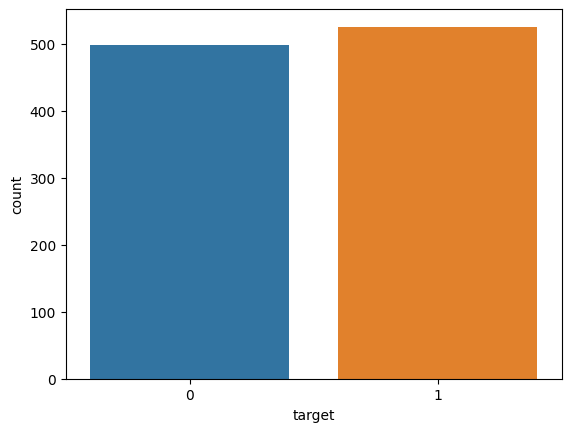

In [209]:
sns.countplot(x="target", data=df)
plt.show()

Датасет хорошо сбалансирован: количество элементов обоих классов примерно совпадают.

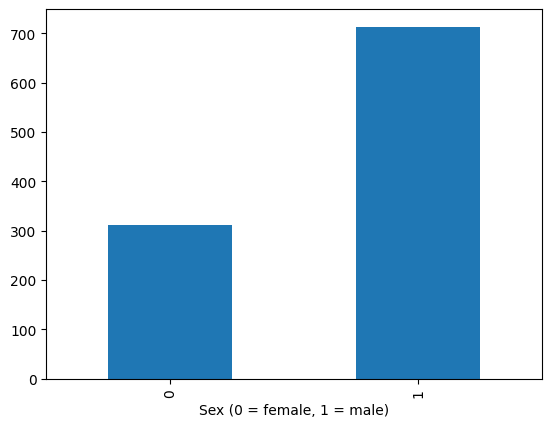

In [210]:
desease_count = df['target'].groupby(df['sex']).count().plot.bar(xlabel="Sex (0 = female, 1 = male)")

Датасет содержит больше данных пациентов мужского пола.

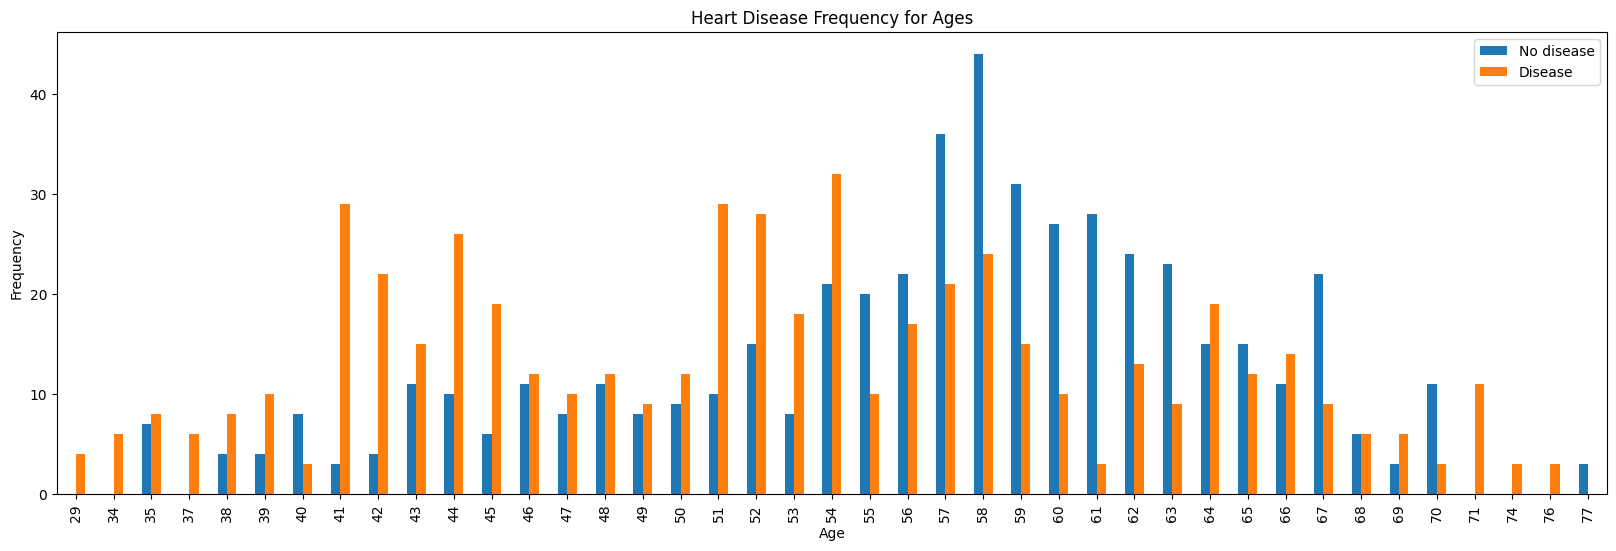

In [211]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No disease", "Disease"])
plt.show()

Заметен резкий скачок пациентов с заболеванем в возрасте применрно 40 лет. Скорее всего, это связано с тем, что именно в этот период люди начинают чаще обращаться к врачам. Также заметно, что примерно в возрасте 50-60 лет высокое количество пациентов без заболеваний: скорее всего, в силу возраста люди часто обращаются к врачам по различным причинам, которые могут быть не связаны с заболеванием.

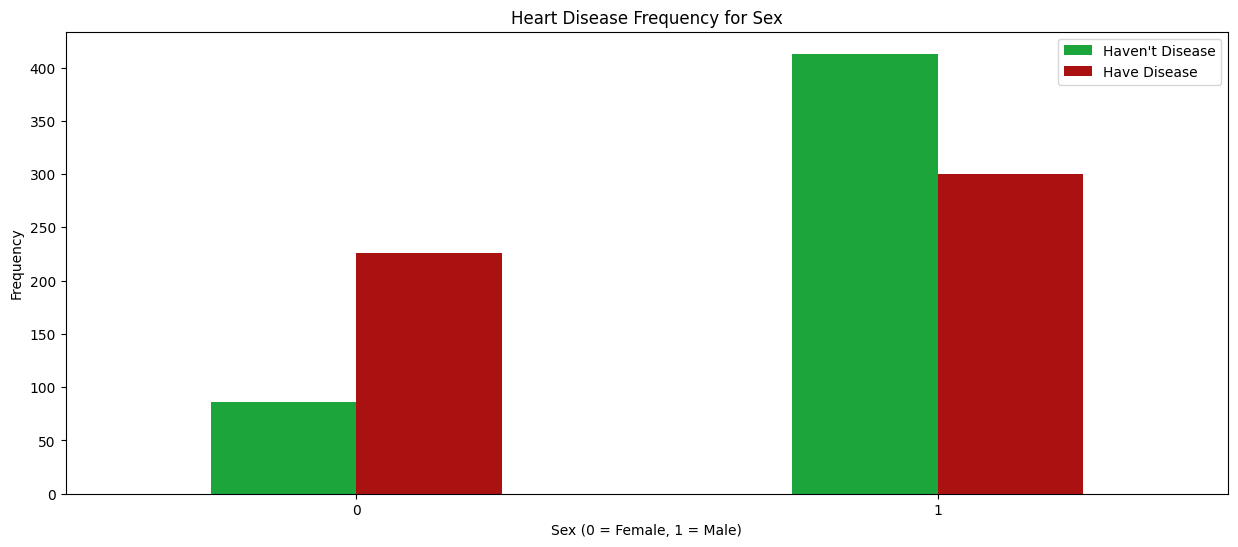

In [212]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

Можно отметить, что среди женщин большее количество пациентов с заболеванием, чем среди мужчин. Учитывая то, что датасет содержит больше данных о пациентах мужского пола, можно предположить, что мужчины чаще обращаются к врачам по поводу проблем с сердцем, и чаще всего это не связано с заболеванием.

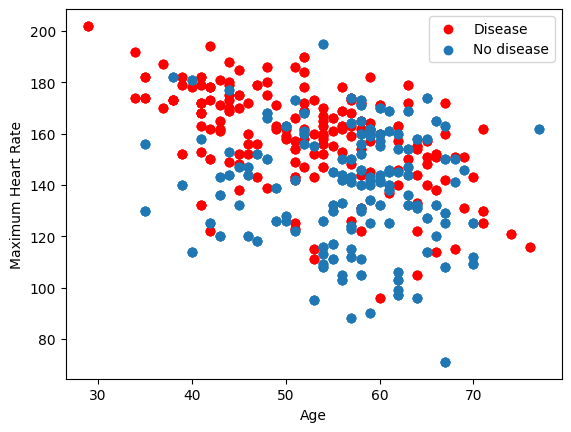

In [213]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "No disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

Здесь видна небольшая закономерность: если у пациента в возрасте 40-50 лет повышенный пульс, то с большой вероятностью у него будет обнаружено заболевание. При этом для пациентов в возрасте 60 лет это уже неверно: случаи заболевания уже не так связаны с пульсом.

Посмотрим, как связано наличия заболевания с типом боли

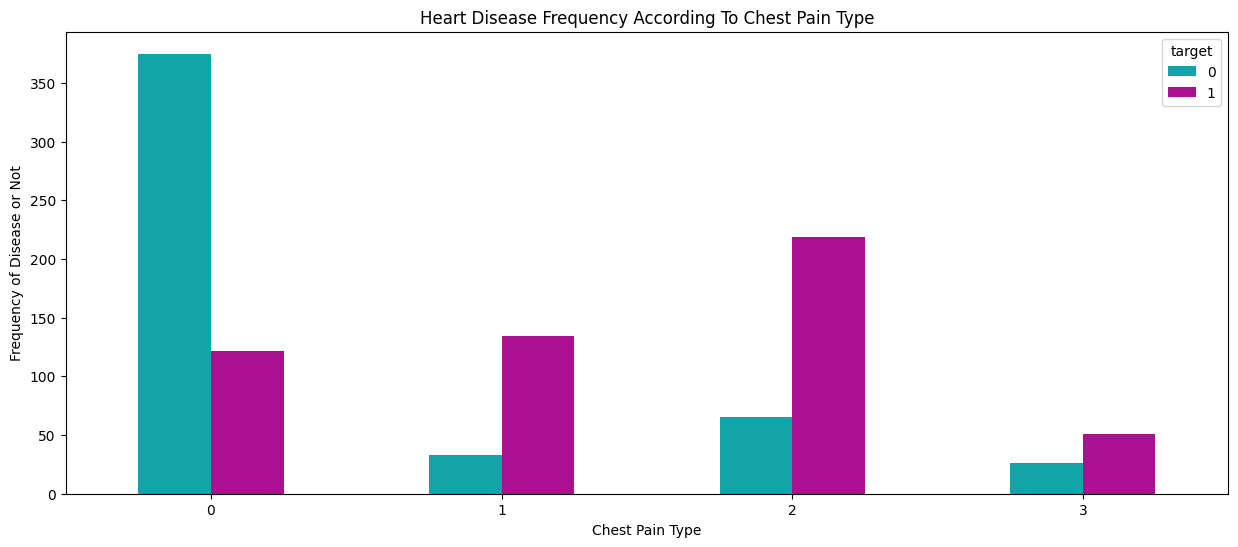

In [214]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15, 6), color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

Боль типа 0 -- самая часто встречающаяся, и в большинстве случаев не указывает на наличие заболевания. Боли типов 1,2,3 встречаются уже не так часто, но в большинстве случаев связаны с заболеванием. При этом наиболее "подозрительная" боль -- боль типа 2. Она тоже часто встречается, и при этом в большинстве случаев указывет на заболевание.

##Обучение моделей

Закодируем категориальные признаки с помощью dummy code

In [215]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


Обучим каждую модель, используя подбор параметров и кросс-валидацию.

Разобъем датасет на обучающую и тествую выборку, а также произведём масштабирование.

In [216]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=RANDOM_STATE)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


###Logistic regression

In [217]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=RANDOM_STATE)

C_grid = [1e-3, 1e-2, 1e-1]
searcher = GridSearchCV(lr, {'C': C_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_lr = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'C': 0.01}
Best score:  0.854933954933955


In [218]:
mlrc = MyLogRegClassifier()  # собственная реализация

lr_grid = [1e-3, 1e-2, 1e-1]
alpha_grid = [1e-3, 1e-2, 1e-1]

searcher = GridSearchCV(mlrc, {'lr': lr_grid, 'alpha': alpha_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_my_lrc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'alpha': 0.001, 'lr': 0.001}
Best score:  0.8549630924630923


###SVM


In [219]:
from sklearn.svm import SVC

svc = SVC(random_state=RANDOM_STATE)

C_grid = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel_grid = ["linear", "rbf"]
gamma_grid = ["scale", "auto", 1e-4, 1e-3, 1e-2, 1e-1, 1]

searcher = GridSearchCV(svc, {'C': C_grid, 'kernel': kernel_grid, 'gamma': gamma_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_svc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.9554001554001553


###Custom SVM

In [220]:
my_svc = MySVMClassifier()  # собственная реализация

lambda_grid = np.linspace(1e-4, 1e-1, 5)
alpha_grid = np.linspace(1e-4, 1e-1, 5)

searcher = GridSearchCV(my_svc, {'Lambda': lambda_grid, 'alpha': alpha_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_my_svc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'Lambda': 0.0001, 'alpha': 0.0001}
Best score:  0.800573038073038


###KNN

In [221]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

n_neighbors_grid = np.arange(1, 20, 2)
weights_grid = ['distance', 'uniform']

searcher = GridSearchCV(knc, {'n_neighbors': n_neighbors_grid, 'weights': weights_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_knc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'n_neighbors': 11, 'weights': 'distance'}
Best score:  0.9763111888111888


###Naive bayes

In [222]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_grid = np.logspace(0, -10, 100)

gnb = GaussianNB()
searcher = GridSearchCV(gnb, {'var_smoothing': var_smoothing_grid}, scoring='accuracy', cv=5)

searcher = searcher.fit(X_train_scaled, y_train)
best_gnb = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'var_smoothing': 0.4977023564332111}
Best score:  0.83258547008547


###Decision tree

In [223]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

criterion_grid = ["gini", "entropy", "log_loss"]
max_features_grid = [None, 0.5, 2, 5, 10]
min_samples_split_grid = [2, 3, 4, 5, 10]

searcher = GridSearchCV(dtc, {'criterion': criterion_grid, 'max_features': max_features_grid, 'min_samples_split': min_samples_split_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_dtc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'criterion': 'entropy', 'max_features': 5, 'min_samples_split': 3}
Best score:  0.9693376068376068


Запустим предсказания обученных моделей с наилучшими параметрами на тестовой выборке.

In [224]:
y_my_lr = best_my_lrc.predict(X_test_scaled)
y_my_svc = best_my_svc.predict(X_test_scaled)

y_lr = best_lr.predict(X_test_scaled)
y_svc = best_svc.predict(X_test_scaled)
y_knc = best_knc.predict(X_test_scaled)
y_gnb = best_gnb.predict(X_test_scaled)
y_dtc = best_dtc.predict(X_test_scaled)

Посмотрим на итоговый accuracy

{'LR': 0.8668831168831169, 'SVM': 0.9902597402597403, 'KNN': 0.9902597402597403, 'NB': 0.8603896103896104, 'DT': 0.9902597402597403, 'MY_LR': 0.8571428571428571, 'MY_SVM': 0.8051948051948052}


<Axes: >

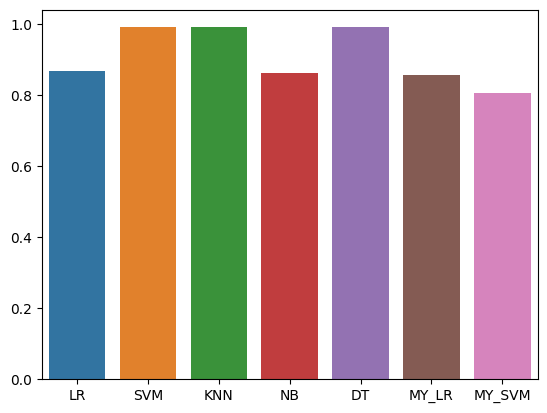

In [225]:
from sklearn.metrics import accuracy_score

scores = {}

scores['LR'] = accuracy_score(y_test, y_lr)
scores['SVM'] = accuracy_score(y_test, y_svc)
scores['KNN'] = accuracy_score(y_test, y_knc)
scores['NB'] = accuracy_score(y_test, y_gnb)
scores['DT'] = accuracy_score(y_test, y_dtc)
scores['MY_LR'] = accuracy_score(y_test, y_my_lr)
scores['MY_SVM'] = accuracy_score(y_test, y_my_svc)

print(scores)
sns.barplot(x=list(scores.keys()), y=list(scores.values()))

 И построим confusion matrices.

In [226]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_lr)
cm_svc = confusion_matrix(y_test, y_svc)
cm_knc = confusion_matrix(y_test, y_knc)
cm_gnb = confusion_matrix(y_test, y_gnb)
cm_dtc = confusion_matrix(y_test, y_dtc)

cm_my_lr = confusion_matrix(y_test, y_my_lr)
cm_my_svc = confusion_matrix(y_test, y_my_svc)

<Axes: title={'center': 'My SVM Classifier Confusion Matrix'}>

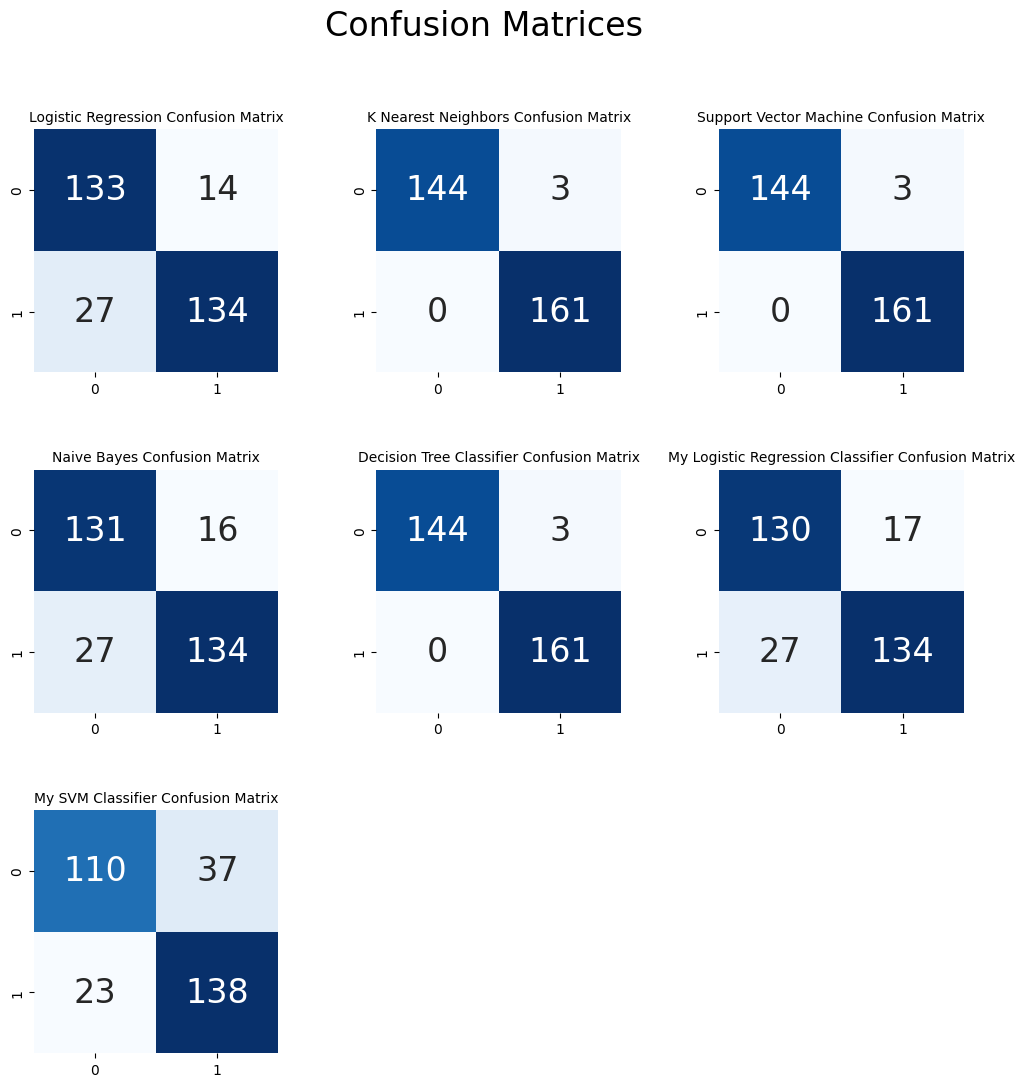

In [227]:
plt.figure(figsize=(12, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,3,1)
plt.title("Logistic Regression Confusion Matrix", fontsize=10)
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("K Nearest Neighbors Confusion Matrix", fontsize=10)
sns.heatmap(cm_knc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,3)
plt.title("Support Vector Machine Confusion Matrix", fontsize=10)
sns.heatmap(cm_svc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("Naive Bayes Confusion Matrix", fontsize=10)
sns.heatmap(cm_gnb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Decision Tree Classifier Confusion Matrix", fontsize=10)
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("My Logistic Regression Classifier Confusion Matrix", fontsize=10)
sns.heatmap(cm_my_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,7)
plt.title("My SVM Classifier Confusion Matrix", fontsize=10)
sns.heatmap(cm_my_svc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

Вывод: на этом датасете точнее всего оказались модели SVM и KNN. За ними идут Naive Bayes, Logistic Regression и собственная реализация My Logitic Regression. Наименьшую точность показала модель My SVM.

#Второй датасет

Датасет содержит данные о параметрах различных образований, обнаруженных в лёгких пациентов с помощью рентгена. Также датасет содержит диагноз, который был поставлен каждому пациенту.

* diagnosis: The diagnosis of breast tissues (0 = malignant, 1 = benign) where malignant denotes that the disease is harmful
* mean_radius: mean of distances from center to points on the perimeter
* mean_texture: standard deviation of gray-scale values
* mean_perimeter: mean size of the core tumor
* mean_area: mean area of the core tumor
* mean_smoothness: mean of local variation in radius lengths

По заданным параметрам опухоли интересно предсказывать диагноз пациента (имеет ли он злокачественную или доброкачественную опухоль)

In [228]:
df = pd.read_csv('Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


В датасете отсутствуют null-значения, а также все нецелевые признаки являются количественными.

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [230]:
df.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

##EDA

Обратим внимание, что датасет не очень хорошо сбалансирован: количество пациентов с доброкачественной опухолью (1) примерно в 1.5 раза больше, чем пациентов со злокачественной (0).

In [231]:
df['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

[Text(0.5, 0, 'Diagnosis (0 = bad, 1 = good)')]

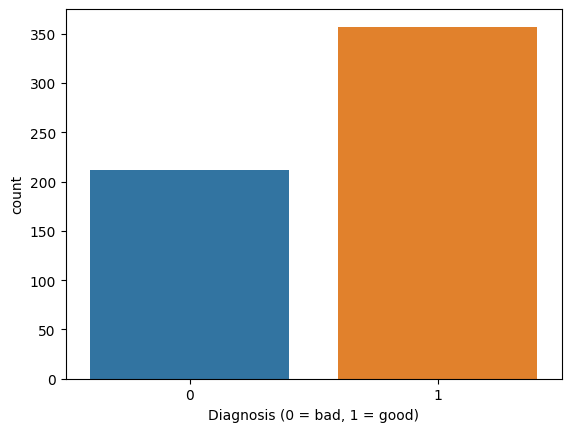

In [232]:
ax = sns.countplot(df, x='diagnosis')
ax.set(xlabel='Diagnosis (0 = bad, 1 = good)')

Построим на матрицу корреляции

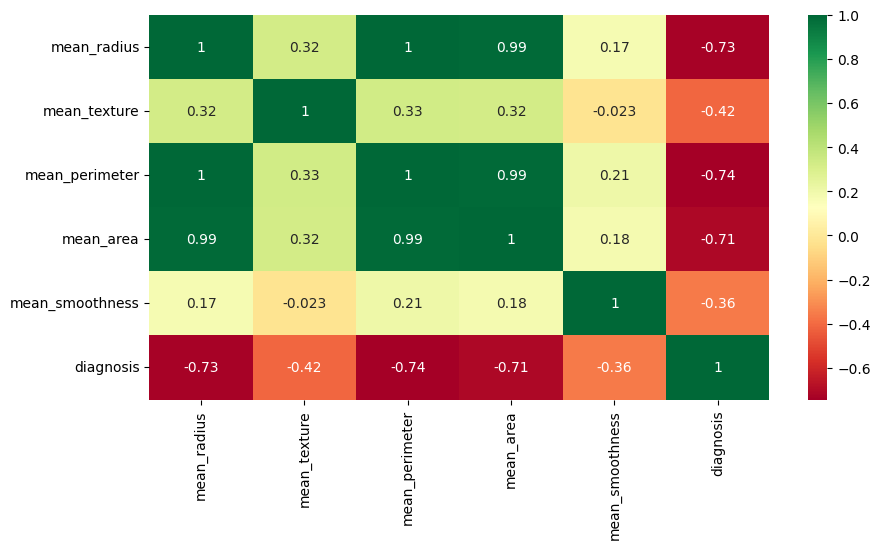

In [233]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Отметим, что mean_radius, mean_perimiter mean_area -- признаки, описывающие геометрические параметры опухоли, поэтому они сильно коррелируют между собой. Для чистоты уберём признак mean_radius из рассмотрения. Также заметно, что почти все признаки имеют существенную корреляцию с целевым признаком.

In [234]:
df = df.drop('mean_perimeter', axis=1)

Рассмотрим зависимости признаков между собой.

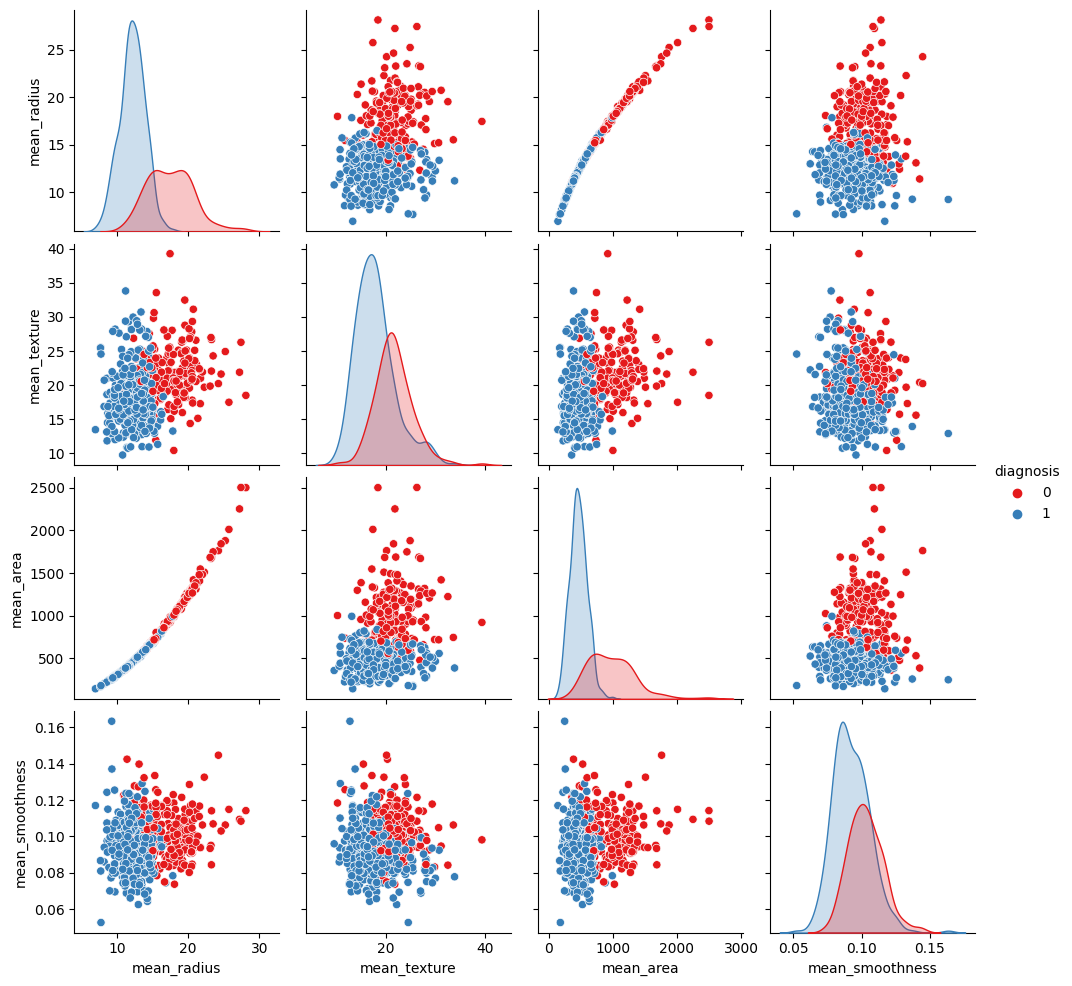

In [235]:
sns.pairplot(df, hue='diagnosis', palette="Set1")

Отметим, что по всем признакам можно довольно хорошо предсказывать целевой признак. При этом, как и ожидается, между mean_area и mean_radius (площадь и радиус опухоли) хорошо видна некая квадратичная зависимость. Кроме того, именно по геометрическим признакам (размеру опухоли) можно предсказывать наиболее уверенно.

##Обучение моделей

Разобъем датасет на обучающую и тествую выборку, а также произведём масштабирование.

In [236]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

y = df['diagnosis']
X = df.drop(columns=['diagnosis'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=RANDOM_STATE)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###Logistic regression

In [237]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=RANDOM_STATE)

C_grid = [1e-3, 1e-2, 1e-1]
searcher = GridSearchCV(lr, {'C': C_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_lr = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'C': 0.1}
Best score:  0.9170886075949367


In [238]:
mlrc = MyLogRegClassifier()  # собственная реализация

lr_grid = [1e-3, 1e-2, 1e-1]
alpha_grid = [1e-3, 1e-2, 1e-1]

searcher = GridSearchCV(mlrc, {'lr': lr_grid, 'alpha': alpha_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_my_lrc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'alpha': 0.001, 'lr': 0.001}
Best score:  0.9145253164556962


###SVM


In [239]:
from sklearn.svm import SVC

svc = SVC(random_state=RANDOM_STATE)

C_grid = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel_grid = ["linear", "rbf"]
gamma_grid = ["scale", "auto", 1e-4, 1e-3, 1e-2, 1e-1, 1]

searcher = GridSearchCV(svc, {'C': C_grid, 'kernel': kernel_grid, 'gamma': gamma_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_svc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'C': 0.75, 'gamma': 'auto', 'kernel': 'rbf'}
Best score:  0.9270886075949367


###Custom SVM

In [240]:
my_svc = MySVMClassifier()  # собственная реализация

lambda_grid = np.linspace(1e-4, 1e-1, 5)
alpha_grid = np.linspace(1e-4, 1e-1, 5)

searcher = GridSearchCV(my_svc, {'Lambda': lambda_grid, 'alpha': alpha_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_my_svc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'Lambda': 0.0001, 'alpha': 0.0001}
Best score:  0.876772151898734


###KNN

In [241]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

n_neighbors_grid = np.arange(1, 20, 2)
weights_grid = ['distance', 'uniform']

searcher = GridSearchCV(knc, {'n_neighbors': n_neighbors_grid, 'weights': weights_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_knc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'n_neighbors': 11, 'weights': 'distance'}
Best score:  0.934620253164557


###Naive bayes

In [242]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_grid = np.logspace(0, -10, 100)

gnb = GaussianNB()
searcher = GridSearchCV(gnb, {'var_smoothing': var_smoothing_grid}, scoring='accuracy', cv=5)

searcher = searcher.fit(X_train_scaled, y_train)
best_gnb = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'var_smoothing': 0.0774263682681127}
Best score:  0.8994936708860759


###Decision tree

In [243]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

criterion_grid = ["gini", "entropy", "log_loss"]
max_features_grid = [None, 0.5, 2, 5, 10]
min_samples_split_grid = [2, 3, 4, 5, 10]

searcher = GridSearchCV(dtc, {'criterion': criterion_grid, 'max_features': max_features_grid, 'min_samples_split': min_samples_split_grid}, scoring='accuracy', cv=5)

searcher.fit(X_train_scaled, y_train)
best_dtc = searcher.best_estimator_
print("Best params: ", searcher.best_params_)
print("Best score: ", searcher.best_score_)

Best params:  {'criterion': 'gini', 'max_features': None, 'min_samples_split': 5}
Best score:  0.9145886075949367


Запустим предсказания обученных моделей с наилучшими параметрами на тестовой выборке

In [244]:
from sklearn.metrics import confusion_matrix

y_my_lr = best_my_lrc.predict(X_test_scaled)
y_my_svc = best_my_svc.predict(X_test_scaled)

y_lr = best_lr.predict(X_test_scaled)
y_svc = best_svc.predict(X_test_scaled)
y_knc = best_knc.predict(X_test_scaled)
y_gnb = best_gnb.predict(X_test_scaled)
y_dtc = best_dtc.predict(X_test_scaled)

Посмотрим на полученные accuracy:

{'LR': 0.9298245614035088, 'SVM': 0.935672514619883, 'KNN': 0.9298245614035088, 'NB': 0.9064327485380117, 'DT': 0.8888888888888888, 'MY_LR': 0.9298245614035088, 'MY_SVM': 0.8713450292397661}


<Axes: >

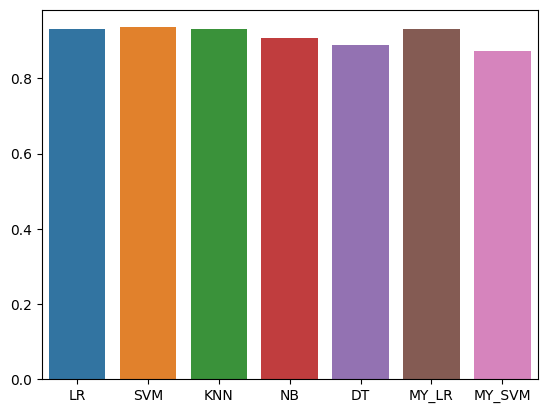

In [245]:
from sklearn.metrics import accuracy_score

scores = {}

scores['LR'] = accuracy_score(y_test, y_lr)
scores['SVM'] = accuracy_score(y_test, y_svc)
scores['KNN'] = accuracy_score(y_test, y_knc)
scores['NB'] = accuracy_score(y_test, y_gnb)
scores['DT'] = accuracy_score(y_test, y_dtc)
scores['MY_LR'] = accuracy_score(y_test, y_my_lr)
scores['MY_SVM'] = accuracy_score(y_test, y_my_svc)

print(scores)
sns.barplot(x=list(scores.keys()), y=list(scores.values()))

Построим confusion matrices.

In [246]:
cm_lr = confusion_matrix(y_test, y_lr)
cm_svc = confusion_matrix(y_test, y_svc)
cm_knc = confusion_matrix(y_test, y_knc)
cm_gnb = confusion_matrix(y_test, y_gnb)
cm_dtc = confusion_matrix(y_test, y_dtc)

cm_my_lr = confusion_matrix(y_test, y_my_lr)
cm_my_svc = confusion_matrix(y_test, y_my_svc)

<Axes: title={'center': 'My SVM Classifier Confusion Matrix'}>

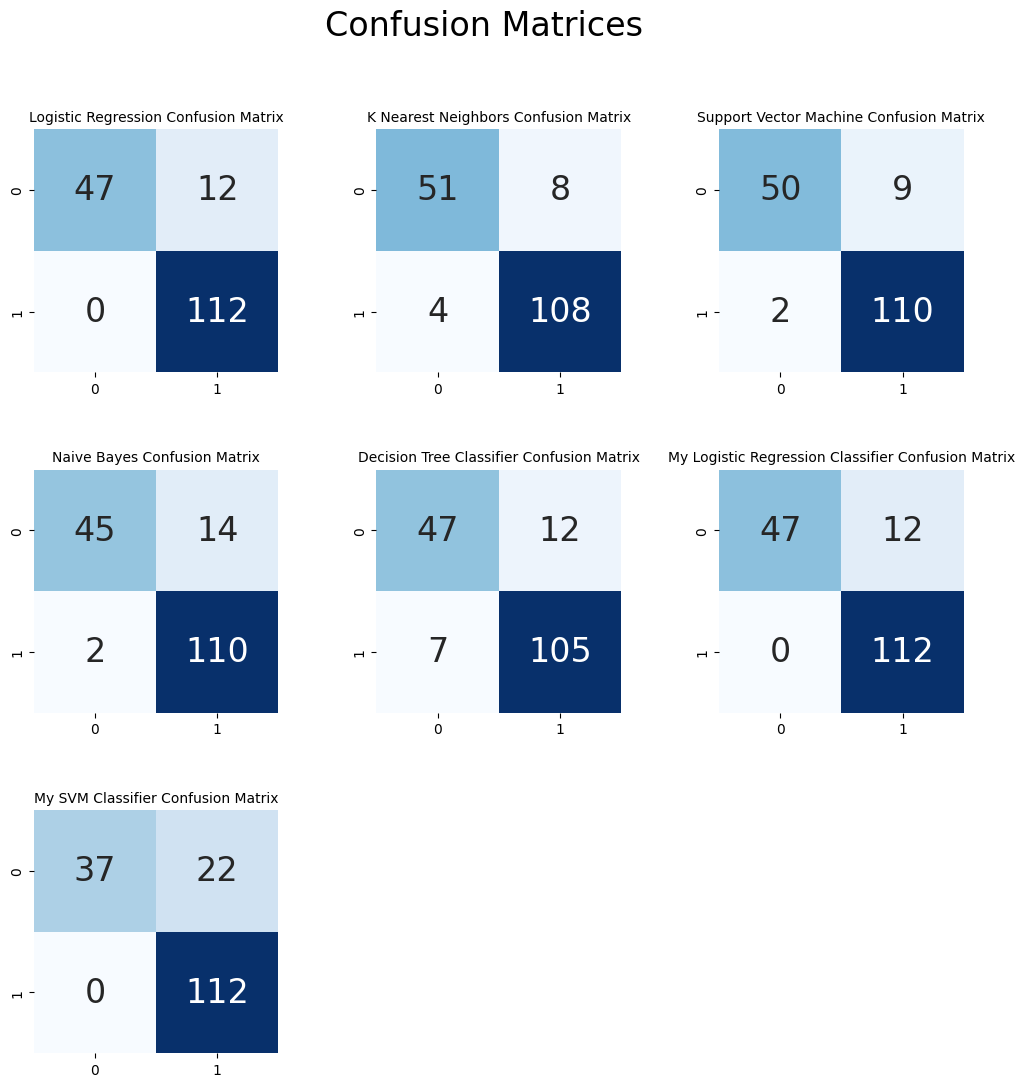

In [247]:
plt.figure(figsize=(12, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,3,1)
plt.title("Logistic Regression Confusion Matrix", fontsize=10)
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("K Nearest Neighbors Confusion Matrix", fontsize=10)
sns.heatmap(cm_knc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,3)
plt.title("Support Vector Machine Confusion Matrix", fontsize=10)
sns.heatmap(cm_svc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("Naive Bayes Confusion Matrix", fontsize=10)
sns.heatmap(cm_gnb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Decision Tree Classifier Confusion Matrix", fontsize=10)
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("My Logistic Regression Classifier Confusion Matrix", fontsize=10)
sns.heatmap(cm_my_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,7)
plt.title("My SVM Classifier Confusion Matrix", fontsize=10)
sns.heatmap(cm_my_svc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

Вывод: на втором датасете наилучшие результаты показали логистическая регрессия, KNN, SVM и собственной реализации My_LR. Самая низкая accuracy снова получилась у My_SVM. Дерево решений не показало такой высокий результат, как на предыдущем датасете.
